# Домашнее задание "Варианционные автоэнкодеры"

**Автор**: Ермекова Асель

В этом домашнем задании вам предстоит реализовать VAE для датасета картинок MNIST.

Вы научитесь обучать вариационный автоэнкодер (VAE) генерировать новые изображения с нуля. А также сможете управлять генерацией, указывая желаемый класс объекта, и оценивать качество результата с помощью метрики FID.

Это домашнее задание состоит из двух частей:

* **I часть.** Реализовать безусловную генерацию картинок при помощи VAE тренированную на датасете MNIST и оценить качество по метрике FID.
* **II часть.** Реализовать условную генерацию по классу и оценить качество по метрике FID.





     

Установите библиотеку для подсчета FID:

In [1]:
!pip install pytorch-fid

## **I часть. Unconditional VAE (6 баллов)**

### Библиотеки

In [2]:
# TODO
# Импортните любые необходимые вам библиотеки
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import torch
import os
import random
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import copy

### Датасет.

**Задание**: Скачайте датасет MNIST и подготовьте train dataloader.

In [3]:
train_dataset = datasets.MNIST(
        root='./data',
        train=True,
        download=True,
        transform=transforms.Compose([
        transforms.ToTensor(), # [0.0, 1.0] float
        transforms.Lambda(lambda x: (x > 0.5).float()) # Binarize
        ])
    )

train_loader = DataLoader(
        train_dataset,
        batch_size=512,
        shuffle=True
    )

test_dataset = datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(), # [0.0, 1.0] float
        transforms.Lambda(lambda x: (x > 0.5).float()) # Binarize
    ])
)

**Задание**: Для FID сохраните 10k реальных изображений из MNIST test части в папку

In [4]:
# TODO: Для FID сохраните 10k реальных изображений из MNIST test части в папку

os.makedirs('mnist_vae_real', exist_ok=True)

for i in range(len(test_dataset)):
    img, _ = test_dataset[i]
    save_image(img, f'mnist_vae_real/real_{i:05d}.png')

**Задание**: Визуализируйте 5 рандомных сэмплов из тренировочных данных и 5 сэмплов из тестовых данных

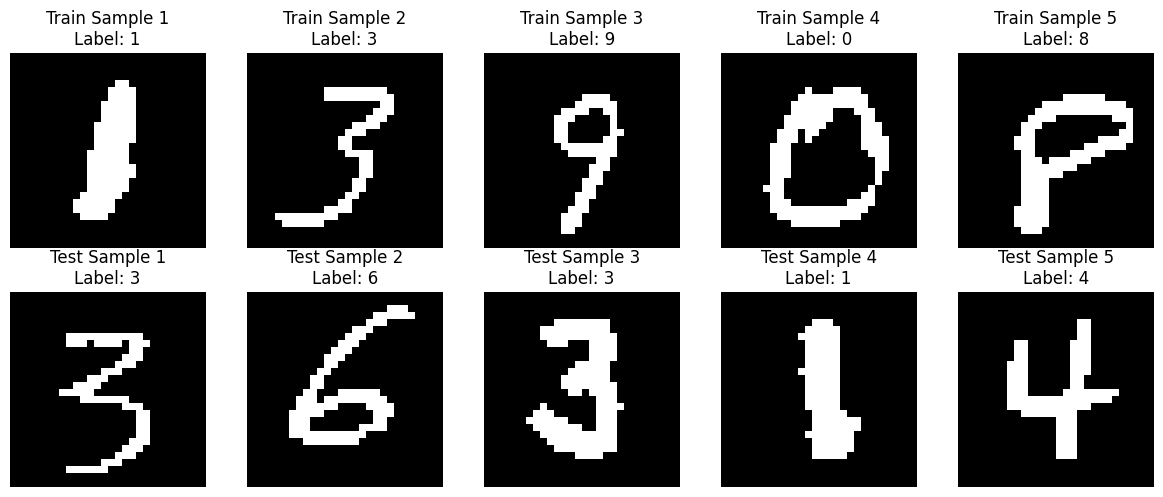

In [5]:
fig, axes = plt.subplots(2, 5, figsize=(12, 5))

for i in range(5):
    id = random.randint(0, len(train_dataset) - 1)
    img, label = train_dataset[id]
    axes[0, i].imshow(img[0], cmap='gray')
    axes[0, i].set_title(f'Train Sample {i+1}\nLabel: {label}')
    axes[0, i].axis('off')

for i in range(5):
    id = random.randint(0, len(test_dataset) - 1)
    img, label = test_dataset[id]
    axes[1, i].imshow(img[0], cmap='gray')
    axes[1, i].set_title(f'Test Sample {i+1}\nLabel: {label}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

### Модель

**Задание**: Реализуйте VAE архитектуру

In [6]:
# TODO: Реализуйте VAE (безусловный)

class VAE(nn.Module):
    def __init__(self, input_dim=1, latent_dim=32, hidden_dim=128):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        # Encoder: изображение -> mu, logvar
        # Decoder: z -> изображение

        self.encoder = nn.Sequential(
            nn.Conv2d(input_dim, 32, 4, 2, 1),  # понизим размерность изображения до 14 на 14
            nn.ReLU(), # добавляем нелинейность
            nn.Conv2d(32, 64, 4, 2, 1), # понизим размерность изображения до 7 на 7
            nn.ReLU(), # добавляем нелинейность
            nn.Flatten(), # вытягиваем в одномерный вектор
            nn.Linear(3136, hidden_dim), # делаем вектор с 128 координатами из вектора с 3136 координатами
            nn.ReLU(), # добавляем нелинейность
            nn.Linear(hidden_dim, 2 * latent_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim), # делаем вектор с 128 координатами из вектора с 32 координатами
            nn.ReLU(), # добавляем нелинейность
            nn.Linear(hidden_dim, 3136), # делаем вектор с 3136 координатами из вектора с 128 координатами
            nn.ReLU(), # добавляем нелинейность
            nn.Unflatten(1, (64, 7, 7)), # делаем 4D-тензор
            nn.ConvTranspose2d(64, 32, 4, 2, 1), # повышаем размерность изображения до 14 на 14
            nn.ReLU(), # добавляем нелинейность
            nn.ConvTranspose2d(32, input_dim, 4, 2, 1), # повышаем размерность изображения до 28 на 28
            nn.Sigmoid() # ф-я активации, которая предсказывает класс пикселя
        )

    def encode(self, x):
        h = self.encoder(x)
        mu, logvar = h.chunk(2, dim=-1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        p_recon = self.decode(z)
        return p_recon, mu, logvar, z

### Loss

**Задание**: Напишите VAE Loss

In [7]:
# TODO: Реализуйте функцию потерь VAE (подходит и для CVE)

def vae_loss(p_recon, x, mu, logvar):
    # Reconstruction loss: BCE (since output is sigmoid)
    recon_loss = F.binary_cross_entropy(p_recon, x, reduction='sum')
    # KL divergence: D_KL(q(z|x) || p(z))
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss, recon_loss, kl_loss

### Тренировка

**Задание**: Обучите модель на датасете MNIST.

In [8]:
latent_dim = 32 # MNIST VAEs often use 20–64
hidden_dim = 128
epochs = 25
lr = 1e-3
img_size = 28
channels = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
# TODO: Обучите модель

def train_vae(model, train_loader, epochs=1000):
  optimizer = optim.Adam(model.parameters(), lr=lr)

  train_losses = []
  recon_losses = []
  kl_losses = []
  best_loss = 1e38
  best_model_state = None

  model.train()
  for epoch in range(epochs):
      total_loss = 0
      total_recon = 0
      total_kl = 0
      num_batches = 0

      for i, batch in enumerate(tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')):
          x = batch[0].to(device)
          optimizer.zero_grad()

          p_recon, mu, logvar, z = model(x)
          loss, recon_loss, kl_loss = vae_loss(p_recon, x, mu, logvar)

          loss.backward()
          optimizer.step()

          total_loss += loss.item()
          total_recon += recon_loss.item()
          total_kl += kl_loss.item()
          num_batches += 1

      avg_loss = total_loss / len(train_loader.dataset)
      avg_recon = total_recon / len(train_loader.dataset)
      avg_kl = total_kl / len(train_loader.dataset)

      train_losses.append(avg_loss)
      recon_losses.append(avg_recon)
      kl_losses.append(avg_kl)

      print(f'На эпохе {epoch+1} Loss : {round(avg_loss, 4)}, Recon : {round(avg_recon, 4)}, KL : {round(avg_kl, 4)}')

      if avg_loss < best_loss:
            best_loss = avg_loss
            best_model_state = model.state_dict().copy()

  print(f'\nЛучший Loss: {round(best_loss, 4)}')
  model.load_state_dict(best_model_state)

  return train_losses, recon_losses, kl_losses

In [10]:
vae_model = VAE(input_dim=channels, latent_dim=latent_dim, hidden_dim=hidden_dim).to(device)
vae_train_losses, vae_recon_losses, vae_kl_losses = train_vae(vae_model, train_loader, epochs=epochs)

Epoch 1/25: 100%|██████████| 118/118 [00:09<00:00, 11.93it/s]


На эпохе 1 Loss : 238.5951, Recon : 237.2235, KL : 1.3716


Epoch 2/25: 100%|██████████| 118/118 [00:09<00:00, 12.29it/s]


На эпохе 2 Loss : 191.8604, Recon : 188.2859, KL : 3.5745


Epoch 3/25: 100%|██████████| 118/118 [00:09<00:00, 12.35it/s]


На эпохе 3 Loss : 161.2207, Recon : 150.4278, KL : 10.7929


Epoch 4/25: 100%|██████████| 118/118 [00:11<00:00, 10.09it/s]


На эпохе 4 Loss : 137.7216, Recon : 122.2255, KL : 15.496


Epoch 5/25: 100%|██████████| 118/118 [00:10<00:00, 10.80it/s]


На эпохе 5 Loss : 123.5395, Recon : 105.5416, KL : 17.9979


Epoch 6/25: 100%|██████████| 118/118 [00:09<00:00, 12.78it/s]


На эпохе 6 Loss : 114.9027, Recon : 95.9788, KL : 18.9239


Epoch 7/25: 100%|██████████| 118/118 [00:09<00:00, 12.48it/s]


На эпохе 7 Loss : 107.9592, Recon : 88.1451, KL : 19.8141


Epoch 8/25: 100%|██████████| 118/118 [00:09<00:00, 12.18it/s]


На эпохе 8 Loss : 103.1629, Recon : 83.0329, KL : 20.13


Epoch 9/25: 100%|██████████| 118/118 [00:09<00:00, 12.41it/s]


На эпохе 9 Loss : 99.7749, Recon : 79.4246, KL : 20.3503


Epoch 10/25: 100%|██████████| 118/118 [00:08<00:00, 13.26it/s]


На эпохе 10 Loss : 96.6915, Recon : 75.8154, KL : 20.8761


Epoch 11/25: 100%|██████████| 118/118 [00:09<00:00, 12.58it/s]


На эпохе 11 Loss : 93.9423, Recon : 72.4132, KL : 21.5291


Epoch 12/25: 100%|██████████| 118/118 [00:09<00:00, 12.47it/s]


На эпохе 12 Loss : 91.7479, Recon : 69.6803, KL : 22.0676


Epoch 13/25: 100%|██████████| 118/118 [00:09<00:00, 12.47it/s]


На эпохе 13 Loss : 89.9315, Recon : 67.452, KL : 22.4795


Epoch 14/25: 100%|██████████| 118/118 [00:08<00:00, 13.30it/s]


На эпохе 14 Loss : 88.4846, Recon : 65.6337, KL : 22.851


Epoch 15/25: 100%|██████████| 118/118 [00:10<00:00, 11.65it/s]


На эпохе 15 Loss : 87.2579, Recon : 64.1299, KL : 23.128


Epoch 16/25: 100%|██████████| 118/118 [00:09<00:00, 12.43it/s]


На эпохе 16 Loss : 86.1091, Recon : 62.7228, KL : 23.3862


Epoch 17/25: 100%|██████████| 118/118 [00:09<00:00, 12.54it/s]


На эпохе 17 Loss : 85.3192, Recon : 61.7325, KL : 23.5868


Epoch 18/25: 100%|██████████| 118/118 [00:08<00:00, 13.25it/s]


На эпохе 18 Loss : 84.5262, Recon : 60.7613, KL : 23.7649


Epoch 19/25: 100%|██████████| 118/118 [00:09<00:00, 12.56it/s]


На эпохе 19 Loss : 83.9453, Recon : 60.0324, KL : 23.9129


Epoch 20/25: 100%|██████████| 118/118 [00:09<00:00, 12.21it/s]


На эпохе 20 Loss : 83.3322, Recon : 59.274, KL : 24.0581


Epoch 21/25: 100%|██████████| 118/118 [00:09<00:00, 12.35it/s]


На эпохе 21 Loss : 82.8806, Recon : 58.7471, KL : 24.1335


Epoch 22/25: 100%|██████████| 118/118 [00:09<00:00, 12.83it/s]


На эпохе 22 Loss : 82.4048, Recon : 58.1625, KL : 24.2423


Epoch 23/25: 100%|██████████| 118/118 [00:09<00:00, 12.98it/s]


На эпохе 23 Loss : 81.9246, Recon : 57.5794, KL : 24.3452


Epoch 24/25: 100%|██████████| 118/118 [00:09<00:00, 12.55it/s]


На эпохе 24 Loss : 81.7476, Recon : 57.3382, KL : 24.4094


Epoch 25/25: 100%|██████████| 118/118 [00:09<00:00, 12.47it/s]

На эпохе 25 Loss : 81.2453, Recon : 56.7711, KL : 24.4742

Лучший Loss: 81.2453


### Метрика

В этом разделе вам необходимо посчитать метрику FID.

**Что такое FID?**

**FID (Fréchet Inception Distance)** — это метрика качества генеративных моделей для изображений, которая измеряет **расстояние между распределениями признаков реальных и сгенерированных изображений** в пространстве предобученной нейросети (обычно Inception-v3).

Чем **ниже FID**, тем **ближе** сгенерированные изображения к реальным — как по **качеству**, так и по **разнообразию**.

Формула FID основана на предположении, что признаки в этом пространстве приблизительно распределены как **многомерное нормальное распределение**:

$$
\text{FID} = \|\mu_r - \mu_g\|^2 + \mathrm{Tr}\left( \Sigma_r + \Sigma_g - 2\sqrt{\Sigma_r \Sigma_g} \right)
$$

где:
- $(\mu_r, \Sigma_r)$ — среднее и ковариационная матрица признаков **реальных** изображений,
- $(\mu_g, \Sigma_g)$ — то же для **сгенерированных** изображений,
- $\mathrm{Tr}(\cdot)$ — след матрицы.

> 🔹 FID = 0 означает полное совпадение распределений.  
> 🔹 Чем выше FID ↑ , тем качество или разнообразие генерации ниже ↓.

**Как считать FID на MNIST?**

Вычислите FID с помощью библиотеки [`pytorch-fid`](https://github.com/mseitzer/pytorch-fid):

```bash
python -m pytorch_fid real_mnist/ fake_mnist/ --device cuda
```

> **Важно**: несмотря на то, что признаки Inception-v3 не оптимальны для рукописных цифр, FID остаётся полезной **относительной метрикой** — она позволяет сравнивать разные модели между собой при одинаковых условиях предобработки.


**Задание:** Сгенерируйте и сохраните 10 тыс. изображений, выберите 10 тыс. реальных изображений из MNIST тестовой выборки и посчитайте FID между реальными и сгенерированными изображениями.

In [ ]:
# TODO: Сгенерируйте и сохраните 10 тыс. изображений для FID в папке mnist_vae_fake

vae_samles = 10000
os.makedirs('mnist_vae_fake', exist_ok=True)

with torch.no_grad():
    z = torch.randn(vae_samles, vae_model.latent_dim).to(device)
    vae_fake_images = vae_model.decode(z)
    vae_fake_binary = (vae_fake_images > 0.5).float()
    for i in range(vae_samles):
        save_image(vae_fake_binary[i], f'mnist_vae_fake/mnist_vae_fake_{i:05d}.png')

    print('Закончил')

Закончил


In [12]:
# Чтобы вычислить FID, запустите в терминале:
!pip install pytorch-fid
!python -m pytorch_fid mnist_vae_real mnist_vae_fake --device cuda

100% 200/200 [00:37<00:00,  5.35it/s]
100% 200/200 [00:38<00:00,  5.21it/s]
FID:  7.260305620650172


## **II Часть. Conditional VAE (6 баллов)**


Мы уже научились обучать обычный VAE на датасете картинок и получать новые картинки. Давайте теперь научимся обучать модель, которая сможет генерировать не просто рандомную картинку, которая похожа на картинки из датасета, а картинку из конкретного класса. Например, в MNIST датасете 10 классов (от 1 до 10) и мы хотим говорить модели "Сгенерируй мне только конкретно картинку с числом 3." и она должна теперь уже сгенерировать только картинку с числом 3. Как раз Conditional VAE это должен уметь делать и генерировать картинку, обуславливаясь на конкретный класс.


**Задание**. В этой части домашнего задания вам предстоит обучить Conditional VAE на MNIST. Это значит, что модель на вход должна принимать картинку и класс картинки.

**Метрика**. Вам нужно сгенерировать 1000 сэмплов на каждый класс и посчитать FID для каждого класса.

In [13]:
# TODO: Реализуйте Condiional VAE — добавьте one-hot класс как вход в encoder и decoder

class CVAE(nn.Module):
    def __init__(self, input_dim=1, latent_dim=32, hidden_dim=128, num_classes=10):
        super(CVAE, self).__init__()
        # TODO
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.hidden_dim = hidden_dim
        self.input_dim = input_dim

        # Архитектура как в VAE
        self.encoder = nn.Sequential(
            nn.Conv2d(input_dim + num_classes, 32, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3136, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2 * latent_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + num_classes, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 3136),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, input_dim, 4, 2, 1),
            nn.Sigmoid()
        )

    def encode(self, x, c):
        # TODO: конкатенируйте x и c по каналам
        c = c.view(c.size(0), c.size(1), 1, 1).expand(-1, -1, x.size(2), x.size(3))
        x = torch.cat([x, c], dim=1)
        h = self.encoder(x)
        mu, logvar = h.chunk(2, dim=-1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c):
        # TODO: конкатенируйте z и c
        z = torch.cat([z, c], dim=1)
        return self.decoder(z)

    def forward(self, x, c):
        # TODO
        mu, logvar = self.encode(x, c)
        z = self.reparameterize(mu, logvar)
        p_recon = self.decode(z, c)
        return p_recon, mu, logvar, z

In [14]:
# TODO: Обучите CVAE

def train_cvae(model, train_loader, epochs=1000):
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    recon_losses = []
    kl_losses = []
    best_loss = 1e38
    best_model_state = None

    model.train()
    for epoch in range(epochs):
        total_loss = 0
        total_recon = 0
        total_kl = 0
        num_batches = 0

        for i, batch in enumerate(tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')):
            x = batch[0].to(device)
            optimizer.zero_grad()

            p_recon, mu, logvar, z = model(x, F.one_hot(batch[1], model.num_classes).float().to(device))
            loss, recon_loss, kl_loss = vae_loss(p_recon, x, mu, logvar) # для CVAE ф-я потерь точно такая же, как и для VAE

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_recon += recon_loss.item()
            total_kl += kl_loss.item()
            num_batches += 1

        avg_loss = total_loss / len(train_loader.dataset)
        avg_recon = total_recon / len(train_loader.dataset)
        avg_kl = total_kl / len(train_loader.dataset)

        train_losses.append(avg_loss)
        recon_losses.append(avg_recon)
        kl_losses.append(avg_kl)

        print(f'На эпохе {epoch+1} Loss : {round(avg_loss, 4)}, Recon : {round(avg_recon, 4)}, KL : {round(avg_kl, 4)}')

        if avg_loss < best_loss:
              best_loss = avg_loss
              best_model_state = copy.deepcopy(model.state_dict())

    print(f'\nЛучший Loss: {round(best_loss, 4)}')
    model.load_state_dict(best_model_state)

    return train_losses, recon_losses, kl_losses

In [15]:
num_classes = 10
cvae_model = CVAE(input_dim=channels, latent_dim=latent_dim, hidden_dim=hidden_dim, num_classes=num_classes).to(device)
cvae_train_losses, cvae_recon_losses, cvae_kl_losses = train_cvae(cvae_model, train_loader, epochs=epochs)

Epoch 1/25: 100%|██████████| 118/118 [00:14<00:00,  8.23it/s]


На эпохе 1 Loss : 226.2578, Recon : 224.1962, KL : 2.0616


Epoch 2/25: 100%|██████████| 118/118 [00:08<00:00, 13.14it/s]


На эпохе 2 Loss : 168.9502, Recon : 161.8469, KL : 7.1033


Epoch 3/25: 100%|██████████| 118/118 [00:09<00:00, 12.27it/s]


На эпохе 3 Loss : 128.6188, Recon : 114.1587, KL : 14.46


Epoch 4/25: 100%|██████████| 118/118 [00:09<00:00, 12.20it/s]


На эпохе 4 Loss : 110.1229, Recon : 92.8585, KL : 17.2644


Epoch 5/25: 100%|██████████| 118/118 [00:09<00:00, 12.23it/s]


На эпохе 5 Loss : 100.186, Recon : 81.5671, KL : 18.6189


Epoch 6/25: 100%|██████████| 118/118 [00:09<00:00, 12.63it/s]


На эпохе 6 Loss : 93.9578, Recon : 74.6819, KL : 19.276


Epoch 7/25: 100%|██████████| 118/118 [00:09<00:00, 12.62it/s]


На эпохе 7 Loss : 89.8649, Recon : 70.0871, KL : 19.7778


Epoch 8/25: 100%|██████████| 118/118 [00:10<00:00, 11.19it/s]


На эпохе 8 Loss : 86.8698, Recon : 66.745, KL : 20.1248


Epoch 9/25: 100%|██████████| 118/118 [00:09<00:00, 12.25it/s]


На эпохе 9 Loss : 84.8843, Recon : 64.4461, KL : 20.4382


Epoch 10/25: 100%|██████████| 118/118 [00:09<00:00, 12.25it/s]


На эпохе 10 Loss : 83.0606, Recon : 62.3105, KL : 20.7501


Epoch 11/25: 100%|██████████| 118/118 [00:09<00:00, 12.96it/s]


На эпохе 11 Loss : 81.7496, Recon : 60.8015, KL : 20.9481


Epoch 12/25: 100%|██████████| 118/118 [00:09<00:00, 12.24it/s]


На эпохе 12 Loss : 80.6165, Recon : 59.4471, KL : 21.1694


Epoch 13/25: 100%|██████████| 118/118 [00:09<00:00, 12.33it/s]


На эпохе 13 Loss : 79.6981, Recon : 58.3761, KL : 21.322


Epoch 14/25: 100%|██████████| 118/118 [00:09<00:00, 12.26it/s]


На эпохе 14 Loss : 78.9108, Recon : 57.4596, KL : 21.4513


Epoch 15/25: 100%|██████████| 118/118 [00:09<00:00, 12.45it/s]


На эпохе 15 Loss : 78.2393, Recon : 56.6555, KL : 21.5839


Epoch 16/25: 100%|██████████| 118/118 [00:09<00:00, 13.00it/s]


На эпохе 16 Loss : 77.5725, Recon : 55.8859, KL : 21.6866


Epoch 17/25: 100%|██████████| 118/118 [00:09<00:00, 12.15it/s]


На эпохе 17 Loss : 76.9405, Recon : 55.1596, KL : 21.7809


Epoch 18/25: 100%|██████████| 118/118 [00:09<00:00, 12.11it/s]


На эпохе 18 Loss : 76.4016, Recon : 54.4744, KL : 21.9272


Epoch 19/25: 100%|██████████| 118/118 [00:09<00:00, 12.35it/s]


На эпохе 19 Loss : 75.9534, Recon : 53.9477, KL : 22.0057


Epoch 20/25: 100%|██████████| 118/118 [00:09<00:00, 13.06it/s]


На эпохе 20 Loss : 75.5222, Recon : 53.437, KL : 22.0851


Epoch 21/25: 100%|██████████| 118/118 [00:09<00:00, 12.30it/s]


На эпохе 21 Loss : 75.1616, Recon : 52.9812, KL : 22.1804


Epoch 22/25: 100%|██████████| 118/118 [00:09<00:00, 12.29it/s]


На эпохе 22 Loss : 74.7717, Recon : 52.5232, KL : 22.2485


Epoch 23/25: 100%|██████████| 118/118 [00:09<00:00, 12.07it/s]


На эпохе 23 Loss : 74.3923, Recon : 52.0691, KL : 22.3232


Epoch 24/25: 100%|██████████| 118/118 [00:09<00:00, 11.82it/s]


На эпохе 24 Loss : 74.0179, Recon : 51.6708, KL : 22.3471


Epoch 25/25: 100%|██████████| 118/118 [00:09<00:00, 13.09it/s]

На эпохе 25 Loss : 73.8167, Recon : 51.4182, KL : 22.3985

Лучший Loss: 73.8167


In [16]:
# TODO: Сгенерируйте 1000 сэмплов для каждого класса при помощи CVAE модели

cvae_samles = 1000
cvae_model.eval()

os.makedirs('fake_per_class', exist_ok=True)

with torch.no_grad():
    for i in range(num_classes):
        class_dir = f'fake_per_class/class_{i}'
        os.makedirs(class_dir, exist_ok=True)

        cvae_fake_images = cvae_model.decode(torch.randn(cvae_samles, cvae_model.latent_dim).to(device), torch.eye(num_classes).to(device)[[i]*cvae_samles])
        cvae_fake_binary = (cvae_fake_images > 0.5).float()

        for j in range(cvae_fake_binary.shape[0]):
            save_image(cvae_fake_binary[j], f'{class_dir}/fake_{j:05d}.png')

    print('Закончил')

Закончил


In [17]:
# TODO: Сохраните 1000 сэмплов для каждого класса из реального датасета MNIST тестовой части

real_mnist_samples = 1000
os.makedirs('real_per_class', exist_ok=True)

class_dict = {i: [] for i in range(10)}
for i, (_, label) in enumerate(test_dataset):
    if len(class_dict[label]) < real_mnist_samples:
        class_dict[label].append(i)

for i, id in class_dict.items():
    class_dir = f'real_per_class/class_{i}'
    os.makedirs(class_dir, exist_ok=True)
    for i, j in enumerate(id):
        img, _ = test_dataset[j]
        save_image(img, f'{class_dir}/real_{i:05d}.png')

print('Закончил')

Закончил


In [18]:
# TODO: Посчитайте FID для каждого класса между сгенерированными и реальными изображениями
# Example:
#print("Class 0")
#!python -m pytorch_fid real_per_class/class_0 fake_per_class/class_0 --device cuda

for i in range(num_classes):
    print(f"\nClass {i}")
    real_dir = f'real_per_class/class_{i}'
    fake_dir = f'fake_per_class/class_{i}'
    !python -m pytorch_fid {real_dir} {fake_dir} --device cuda


Class 0
100% 20/20 [00:04<00:00,  4.89it/s]
100% 20/20 [00:03<00:00,  5.10it/s]
FID:  7.81936842439103

Class 1
100% 20/20 [00:04<00:00,  4.75it/s]
100% 20/20 [00:03<00:00,  5.04it/s]
FID:  14.973688835742252

Class 2
100% 20/20 [00:04<00:00,  4.58it/s]
100% 20/20 [00:03<00:00,  5.09it/s]
FID:  11.772271477459498

Class 3
100% 20/20 [00:04<00:00,  4.76it/s]
100% 20/20 [00:03<00:00,  5.07it/s]
FID:  6.077965681633202

Class 4
100% 20/20 [00:04<00:00,  4.83it/s]
100% 20/20 [00:03<00:00,  5.08it/s]
FID:  9.097561386226971

Class 5
100% 18/18 [00:03<00:00,  4.73it/s]
100% 20/20 [00:03<00:00,  5.09it/s]
FID:  8.482793145766806

Class 6
100% 20/20 [00:04<00:00,  4.91it/s]
100% 20/20 [00:03<00:00,  5.09it/s]
FID:  8.915816865426578

Class 7
100% 20/20 [00:04<00:00,  4.79it/s]
100% 20/20 [00:03<00:00,  5.07it/s]
FID:  10.815421077622602

Class 8
100% 20/20 [00:04<00:00,  4.85it/s]
100% 20/20 [00:03<00:00,  5.05it/s]
FID:  10.37218851342513

Class 9
100% 20/20 [00:04<00:00,  4.74it/s]
100% 20/